In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matrixprofile as mp
import random
import time
import os
from matplotlib.patches import Rectangle
from utils import upload_dataset_with_time, plot_ddos

In [4]:
from mp_utils import *
import warnings
warnings.filterwarnings('ignore')

In [5]:
data_paths = {  'd_ntp'     : 'ntp_ddos_14_minutes.csv',
                'd_udp'     : 'udp_ddos_2_minutes.csv',
                'd_syn'     : 'syn_ddos_3_minutes.csv',
                'd_ldap'    : 'ldap_ddos_9_minutes.csv',
                'd_udp_lag' : 'udp_lag_ddos_7_minutes.csv',
             
                'b_ntp'     : 'ntp_benign_30_minutes.csv',
                'b_syn'     : 'syn_benign_1_minutes.csv',
                'b_ldap'    : 'ldap_benign_5_minutes.csv',
                'b_udp_lag' : 'udp_lag_benign_7_minutes.csv'}

dataset_dict = {}

In [6]:
for data_name, path in data_paths.items():
    data = upload_dataset_with_time(path)
    dataset_dict[data_name] = data

Dataset is loaded in 0.012427099999996472 seconds
Dataset is loaded in 0.003695600000000354 seconds
Dataset is loaded in 0.004087499999997135 seconds
Dataset is loaded in 0.006744600000004652 seconds
Dataset is loaded in 0.005358499999999822 seconds
Dataset is loaded in 0.011922100000006708 seconds
Dataset is loaded in 0.0025715999999960104 seconds
Dataset is loaded in 0.003706199999996329 seconds
Dataset is loaded in 0.004784600000007799 seconds


In [73]:
ntp_df = pd.concat([dataset_dict["b_ldap"], dataset_dict["b_ldap"] , dataset_dict["d_ntp"][:5*60],
                    dataset_dict["b_udp_lag"],
                    dataset_dict["d_syn"], dataset_dict["b_ntp"].iloc[:5*60, :]], axis=0).reset_index(drop=True)
ntp_df = ntp_df.drop(['Flow Bytes/s', ' Flow Packets/s'], axis = 1)

Total Duration Of Traffic is: 30.0 minutes


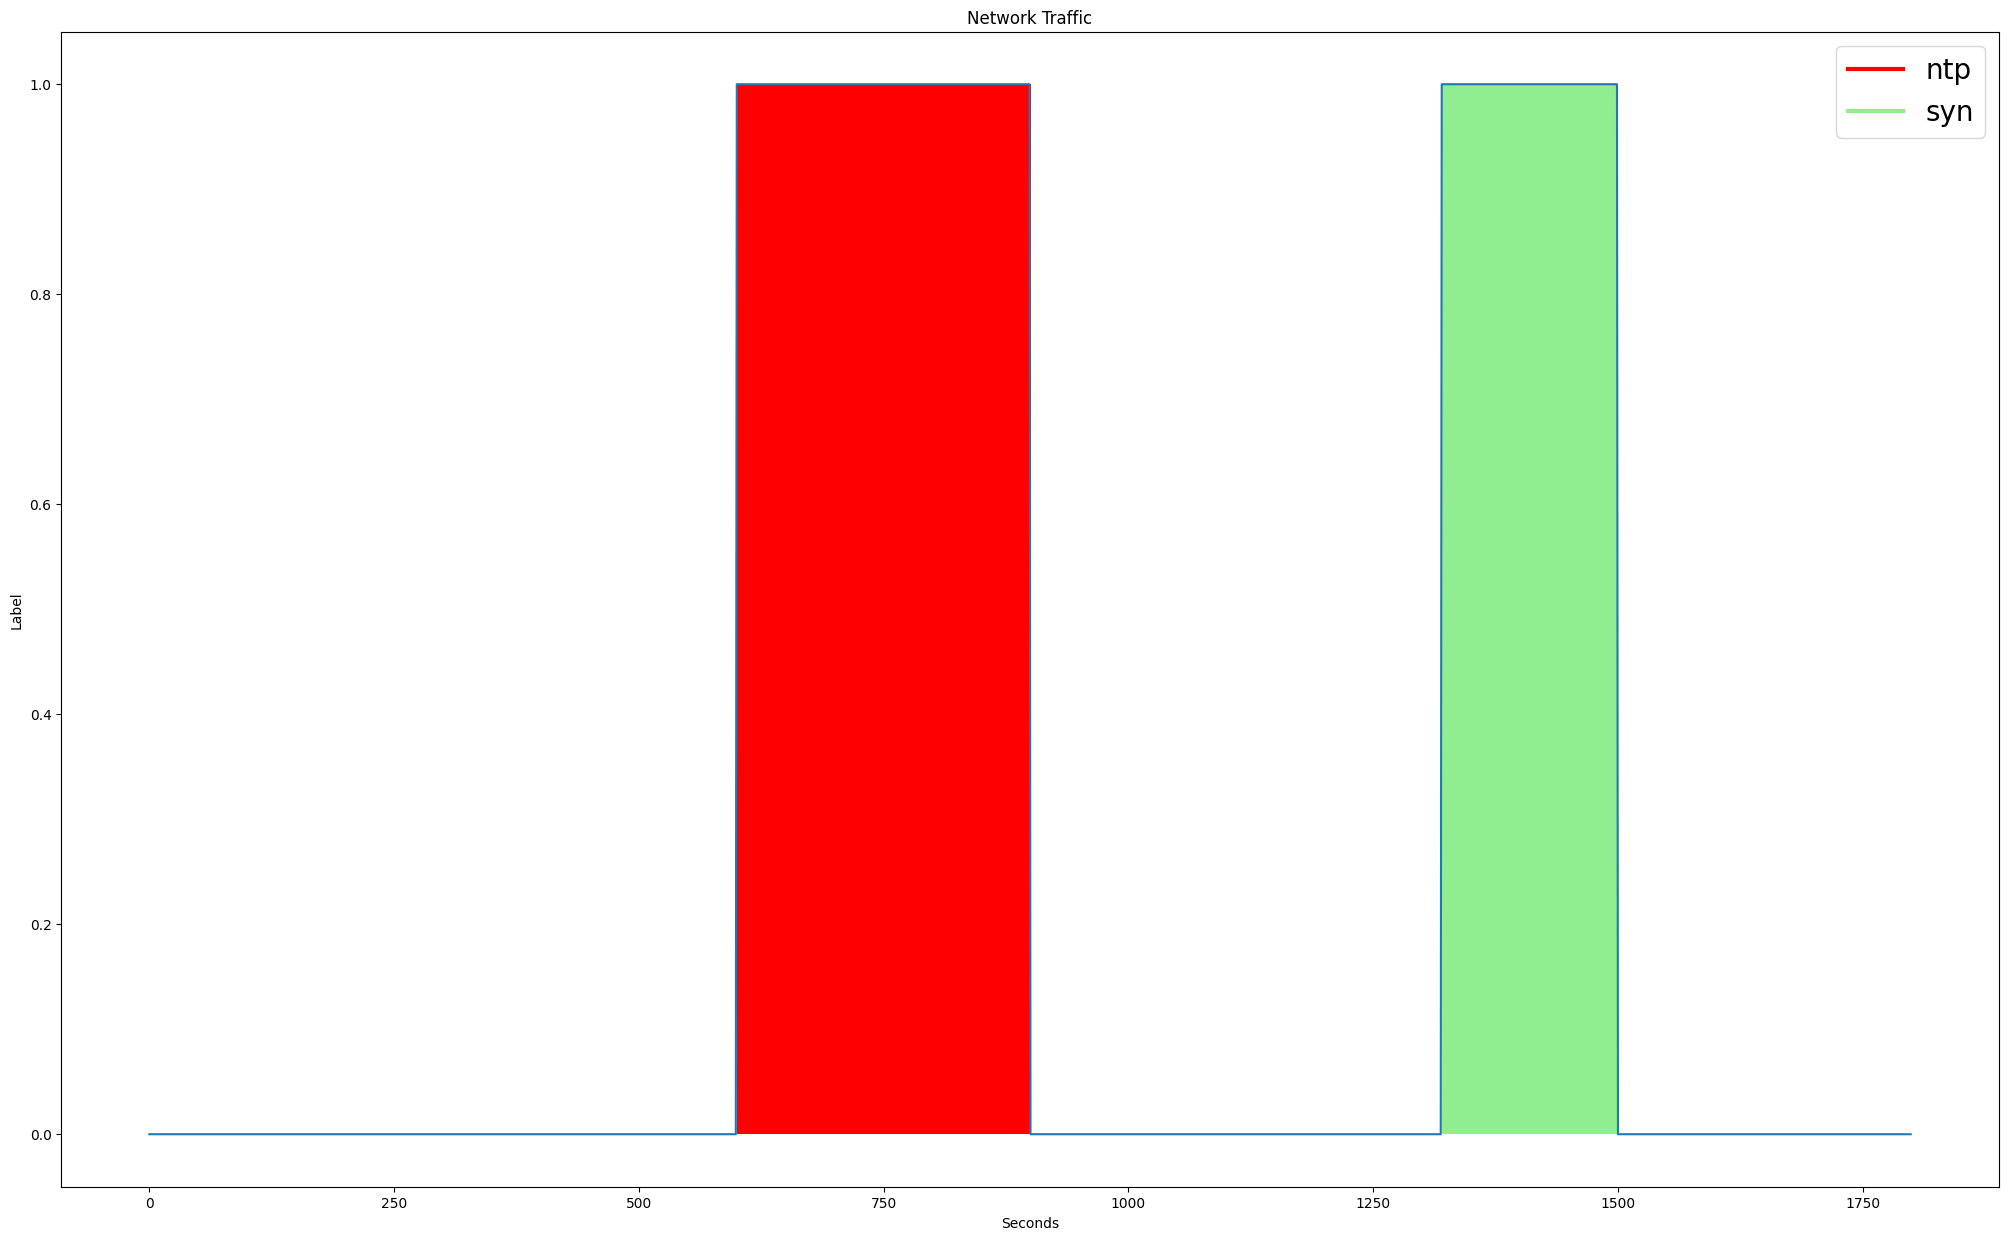

In [74]:
plot_ddos(ntp_df, [('ntp', 5, 10), ('syn', 3, 22)])

In [76]:
X = ntp_df.iloc[:,1:-1]

In [78]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X_scaled = StandardScaler().fit_transform(X)

In [79]:
pd.DataFrame(X_scaled).head(3)

,0,1,2,3,4,5,6,7,8,9,...,44,45,46,47,48,49,50,51,52,53
0,-0.160784,-0.446333,-0.309832,-0.404499,-0.134132,-0.411174,-0.406769,-0.409153,-0.423362,-0.290858,...,-0.328409,-0.381096,-0.494803,0.0,-0.357305,-0.410185,-0.409153,-0.338444,0.0,-0.446333
1,-0.160784,-0.446297,-0.312097,-0.404499,-0.134132,-0.411177,-0.406772,-0.409156,-0.423362,-0.290858,...,-0.328409,-0.635160,-0.494803,0.0,-0.362667,-0.410187,-0.409156,-0.338444,0.0,-0.446297
2,-0.160784,-0.446333,-0.312097,-0.404499,-0.134132,-0.411177,-0.406772,-0.409156,-0.423362,-0.290858,...,-0.328409,-0.635160,-0.494803,0.0,-0.362667,-0.410187,-0.409156,-0.338444,0.0,-0.446333


In [80]:
features = X_scaled.T
cov_matrix = np.cov(features)

In [81]:
cov_matrix.shape

(54, 54)

In [82]:
for i in range(4):
    #diagonal varyanslar 1
    print(cov_matrix[i,i])

1.0005558643690937
1.000555864369094
1.0005558643690946
1.0005558643690942


In [83]:
values, vectors = np.linalg.eig(cov_matrix)
values[:5]

array([15.63833526, 13.01113565,  5.70485287,  2.96751906,  2.3470946 ])

In [84]:
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
 
print(np.sum(explained_variances), "\n", explained_variances)

1.0 
 [0.33254568705725224, 0.27667887743844155, 0.12131241503203292, 0.06310362627109477, 0.049910439554325794, 0.041425705240452866, 0.029100379238632828, 0.020680586183087865, 0.020038626430132853, 0.016135334681155706, 0.0173031155922824, 0.004358549307129562, 0.0016153880535057037, 0.0015893535159501875, 0.0010882258491635192, 0.0007503046066948963, 0.0008421826550449561, 0.000586374063423617, 0.0002771445748112418, 0.00023664532723436892, 0.0001561450996519892, 0.00013970698446790799, 6.0366947947605175e-05, 2.486356149216896e-05, 2.0451141109402044e-05, 7.096207228309467e-06, 5.273491262634337e-06, 3.1723780115404514e-06, 1.851682875443586e-06, 7.925762489671858e-07, 5.264641453556693e-07, 4.838110543324825e-07, 1.0657392066666893e-07, 8.596826188894277e-08, 6.350661384377714e-08, 2.6665556561069548e-08, 1.4665341078941559e-08, 6.50791193710255e-09, 2.212927714729148e-09, 1.8636804281695762e-09, 6.072966410039809e-10, 3.876366069776933e-10, 2.350718997669205e-11, 2.1871455715059

In [86]:
projected_1 = X_scaled.dot(vectors.T[0])
projected_2 = X_scaled.dot(vectors.T[1])
res = pd.DataFrame(projected_1, columns=["PC1"])
res["PC2"] = projected_2
res["Y"] = ntp_df.Label.to_list()
res.head()

,PC1,PC2,Y
0,0.275274,-1.499521,0
1,0.276935,-1.479600,0
2,0.276916,-1.479614,0
3,0.276919,-1.479604,0
4,0.275111,-1.499468,0


In [93]:
def PCA_boyut_secimi(dataframe, varyans = 0.9):
    
    X = dataframe.copy()
    
    from sklearn.preprocessing import StandardScaler
    sc = StandardScaler()
    X_scaled = sc.fit_transform(X)
    
    from sklearn.decomposition import PCA

    #önce component sayısı belirlemeden, pca'yi eğitiyoruz
    pca = PCA(whiten = False).fit(X_scaled)
    
    #eğitilmiş pca'de cumulative sum işlemini kullanarak beklenen komponent - varyans oranını hesaplıyoruz
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10), sharey = False)
    ax[0].plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2) #explained varianca ratio
    ax[0].set_xlabel('Komponent Sayısı')
    ax[0].set_ylabel('Total Varyans')
    ax[0].set_yticks(np.arange(0, 1.1, 0.1))
    ax[0].axvline(6, c = 'b')
    ax[0].axhline(0.9, c = 'r')
    ax[0].set_title('Komponent Sayısı - İfade Edilen Varyans')

    #Bar Plot Gösterim
    #beklenen varyans değerini yakalayan ilk componenti kırmızı ile işaretliyoruz.
    #Eğer diğer komponentler, beklenen varyanstan küçükse mavi, büyükse siyah ile işaretliyoruz
    #Sadece en düşük sayıda komponentle en yüksek varyansa sahip olan kırmızı!
    varyans_listesi = list(np.cumsum(pca.explained_variance_ratio_))
    boyutlar_listesi = list(range(0,len(varyans_listesi)))
    color_list = []
    beklenen_varyans = varyans

    for i in varyans_listesi:
        if 'red' in color_list:
            if i > beklenen_varyans:
                color_list.append('black')
                pass
            else:
                color_list.append('blue')
                pass
        else:
            if i > beklenen_varyans:
                color_list.append('red')
            else:
                color_list.append('blue')

    ax[1].bar(boyutlar_listesi, varyans_listesi, color = tuple(color_list))
    ax[1].set_title('Komponent Sayısı - İfade Edilen Varyans')

    plt.show()
    

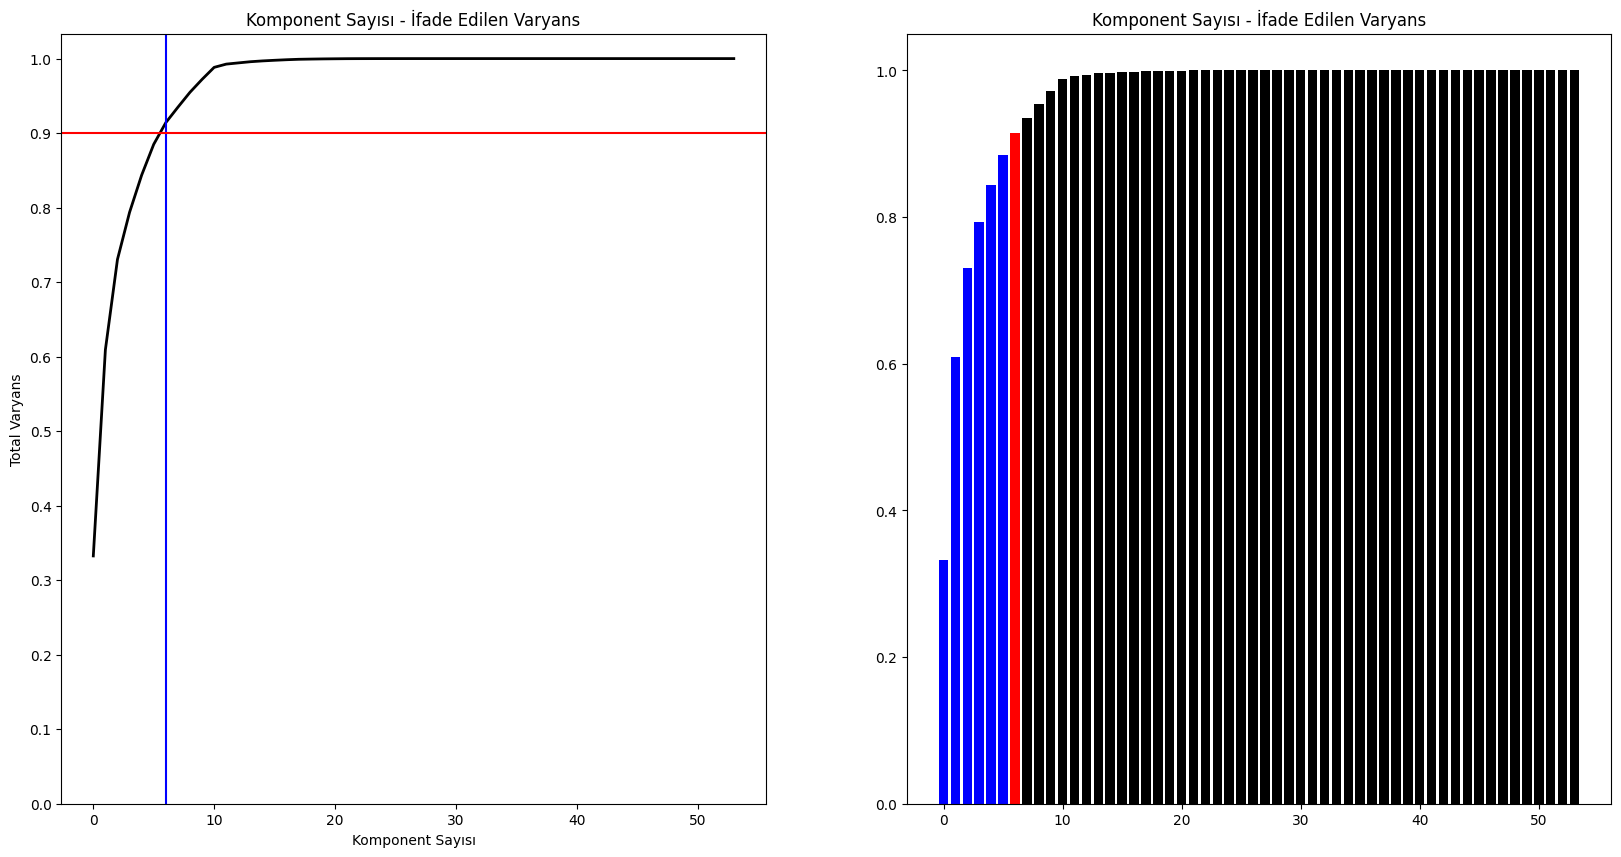

In [94]:
PCA_boyut_secimi(X)

In [144]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
X_scaled = MinMaxScaler().fit_transform(X)

In [145]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 10)

X_pca = pca.fit_transform(X_scaled)

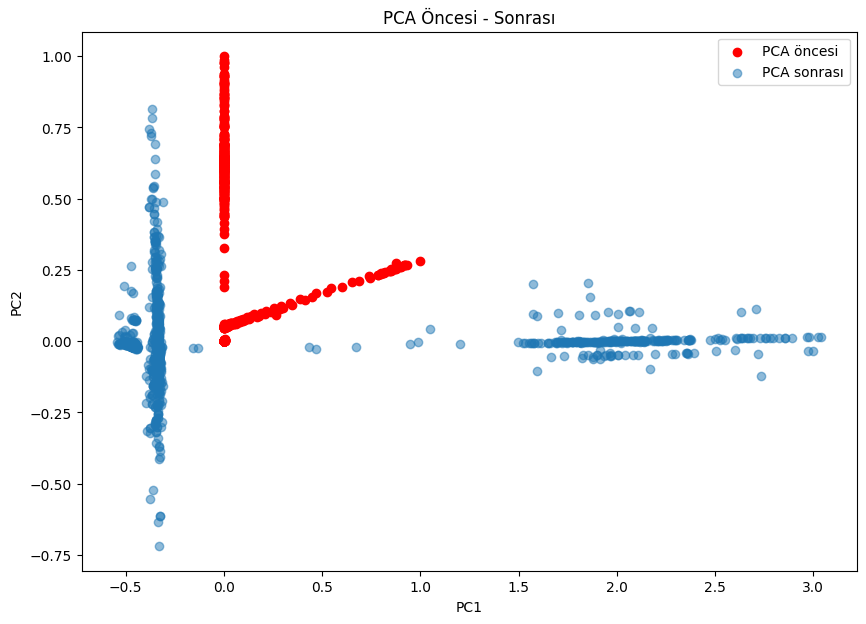

In [146]:
plt.figure(figsize=(10,7))
plt.scatter(X_scaled[:,0], X_scaled[:,1], color = 'red', label = 'PCA öncesi')

plt.scatter(X_pca[:,0], X_pca[:,5], alpha = .5, label = 'PCA sonrası')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Öncesi - Sonrası')
plt.legend()
plt.show()

In [147]:
pca_df = pd.DataFrame(X_pca)
pca_df = pd.concat([pca_df, ntp_df.Label], axis = 1)

In [148]:
pca_df

,0,1,2,3,4,5,6,7,8,9,Label
0,-0.332532,-0.203537,0.023183,-0.157268,-0.045800,-0.019271,-0.016648,0.011216,0.004780,0.004725,0
1,-0.331457,-0.202928,0.021440,-0.167854,-0.061183,-0.027466,-0.015924,0.013044,0.005778,-0.001275,0
2,-0.331462,-0.202919,0.021432,-0.167853,-0.061182,-0.027466,-0.015923,0.013045,0.005773,-0.001276,0
3,-0.331460,-0.202919,0.021432,-0.167853,-0.061182,-0.027466,-0.015923,0.013045,0.005775,-0.001275,0
4,-0.332534,-0.203514,0.023190,-0.157267,-0.045799,-0.019272,-0.016648,0.011213,0.004779,0.004722,0
...,...,...,...,...,...,...,...,...,...,...,...
1795,-0.361147,-0.229780,0.070171,0.152809,0.260100,0.539983,-0.022915,-0.112805,-0.011049,-0.022448,0
1796,-0.341366,-0.211798,0.037567,-0.060938,0.045916,0.161617,-0.019186,-0.028879,0.000178,-0.008346,0
1797,-0.332514,-0.203203,0.024610,-0.157392,-0.045884,-0.019263,-0.016645,0.011467,0.004815,0.004593,0
1798,-0.334100,-0.206387,0.032388,-0.119996,0.017472,-0.076059,-0.012356,0.025455,0.006644,-0.006687,0


In [159]:
MatrixProfileManager.global_df = ntp_df.copy()
threshold_MP_ntp = ThresholdMatrixProfile(pd.DataFrame(pca_df.iloc[:,:-1]), window_size=10, threshold=2.0)
cost, f1_score = threshold_MP_ntp.calculate_cost()
display(threshold_MP_ntp.creport)


{'precision': 0.46346782988004365,
 'recall': 0.8854166666666666,
 'f1-score': 0.6084466714387974,
 'support': 480,
 'accuracy': 0.6961111111111111}

In [160]:
MatrixProfileManager.global_df = ntp_df.copy()
isolation_MP_ntp = IsolationMatrixProfile(pd.DataFrame(pca_df.iloc[:,:-1]), window_size=10)
cost, f1_score = isolation_MP_ntp.calculate_cost()
display(isolation_MP_ntp.creport)

{'precision': 0.35731414868105515,
 'recall': 0.3104166666666667,
 'f1-score': 0.3322185061315496,
 'support': 480,
 'accuracy': 0.6672222222222223}